# Parameterisation

## Overview
**Questions**
- How do I get the parameters for a potential?
- Why is this a limitation of molecular dynamics?

**Objectives**
- Emphasize the requirement to use or develop accurate potential models for the system under study.

Once the function form that is to be used for a particular interaction has been determined, it is necessary to **parameterise** that potential energy function. 
If we think back to the classical electrostatic interaction between two oppositely charged point particles, we set the values of $q_i$ and $q_j$ to be 1 and -1 to model the interaction between a sodium and chloride ion pair. 
This was the parameterisation step of our model. 

For the ion pair with integer charges this is straight-forward. 
However, consider modelling the potential energy between a carbonyl oxygen atom and the hydrogen atom of a water molecule. 
Both of these have some charged character that is **ill defined**, but must be accounted for.

The problem of the correct parameterisation is present for **all** the potential energy functions. 
For the Lennard-Jones function, the parameterisation involves determining the best possible values for $A$ and $B$. 

## How to parameterise a potential model?

The purpose of parameterisation is to create a potential energy model that is able to **accurately reproduce** the energy of a given interaction. 
This means that the parameters should really be obtained by optimising them with respect to a **more accurate** technique than classical simulation. 
Commonly this involves either experimental measurements, e.g. X-ray crystallography, or quantum mechanical calculations; we will be focusing on the latter. 

More can be found out about quantum mechanical calculations in the textbooks mentioned in the introduction (in particular Jeremy Harvey's Computational Chemistry Primer [1]).
However, for our current purposes we only need to remember the previous lesson where it was introduced that quantum calculations are more accurate than classical simulations.

## Information: Quantum mechanical calculations

These are more accurate then classical simulations. However, they are severely limited in the system size, maximum 100s atoms. 

We will stick with the example of a Lennard-Jones interaction, however the arguments and methods discussed are **extensible to all different interaction types**. 
To generate the potential energy model between two particles of argon, we could conduct quantum mechanical calculations at a range of inter-atom separations, from 3 to 8 Å, to find the energy between the two particles.

The Python code below plots the energy vs distances that may be obtained from a quantum mechanical calculation. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

rij = [3e-10, 4e-10, 5e-10, 6e-10, 7e-10, 8e-10]
energy = [127.27e-22, -13.52e-22, -6.37e-22, -1.42e-22, -0.58e-22, -0.25e-22]
energy_err = [12.92e-22, 1.45e-22, 0.54e-22, 0.19e-22, 0.08e-22, 0.04e-22]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.errorbar(rij, energy, yerr=energy_err, marker='o', ls='')
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$E$/J')
plt.show()

<Figure size 800x500 with 1 Axes>

We can already see that the general shape of the curve is similar to a Lennard-Jones (or Buckingham) interaction.
There is a well at the **equilibrium bond distance** and a steep incline as the particles become **too close**. 
It is possible to then fit a Lennard-Jones function to this data, the Python code below does this using a simple least-squares fit.

In [2]:
from scipy.optimize import curve_fit

def lj_energy(rij, a, b):
    """
    Implementation of the Lennard-Jones potential 
    to calculate the energy of the interaction.
    
    Parameters
    ----------
    rij: float
        Distance between particles i and j
    a: float 
        A parameter for interaction between i and j
    b: float 
        B parameter for interaction between i and j
    
    Returns
    -------
    float
        Energy of the interaction between i and j.
    """
    return a / np.power(rij, 12) - b / np.power(rij, 6)
    
popt, pcov = curve_fit(lj_energy, rij, energy, sigma=energy_err)
print('Best value for a = {:.2e} J/m12'.format(popt[0]))
print('Best value for b = {:.2e} J/m6'.format(popt[1]))

Best value for a = 1.25e-134 J/m12
Best value for b = 8.17e-78 J/m6


If we plot a Lennard-Jones function with the values fitted and the quantum mechnical data on a single plot, we can see that there is **relatively good agreement** between the two. 
However, there is some deviation at 4 and 5 Å and therefore more quantum mechnical calculations would **required** to produce a truely accurate forcefield. 

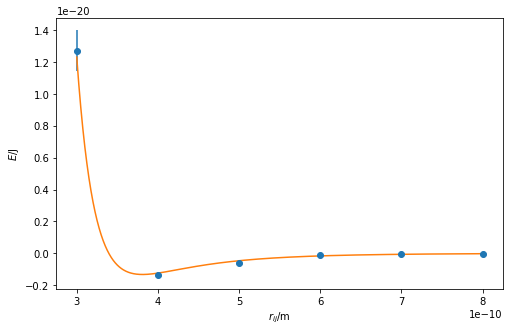

In [3]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.errorbar(rij, energy, yerr=energy_err, marker='o', ls='')
x = np.linspace(3e-10, 8e-10, 1000)
ax.plot(x, lj_energy(x, popt[0], popt[1]))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$E$/J')
plt.show()

Note that it would be necessary to carry out this process for **every** interaction in your calculation, e.g. bonds, angles, dihedrals, van der Waals, and Coulombic. 
Furthmore, it is important to remember the **different chemistry** that is present for each atom. 
For example, the carbon atom is a carbonyl group will not act the same as the carbon atom in a methane molecule. 
To carry out this for *every* molecular dynamics simulation that you wish to perform quickly becomes very unfeasible.

## Off-the-shelf potentials

In an effort to counter the problem of having to develop a new forcefield *every* time someone wanted to perform a molecular dynamics simulation, a variety of off-the-shelf potentials have been developed. 
These are *general* forcefields that as designed to be applied to any system. 

## Information: Off-the-shelf potentials

Although a potential model has been developed with the aim of *generality*, they should still be used with **severe** caution. 
The chemistry in your system may not match directly the system used in the potential generation, which can lead to extreme systematic errors in your the simulations. 

Some examples of off-the-shelf potentials include:
- AMBER: popular for DNA and proteins
- CFF: designed for a broad variety of organic compounds
- CHARMM: widely used for small molecules
- GROMOS: common for biomolecular systems
- OPLS-AA: optimised for liquid simulations

These can be applied to many systems, however as mentioned above they should be used with caution. 
One way to assess an off-the-shelf is to use it to reproduce some simple, but known, property of the material, e.g. density. 

## Mixing rules

Generally these off-the-shelf potentials only give the van der Waals potential for the self interaction.
This is the interaction of a particular atom, with another atom of the same time (e.g. an argon-argon interaction). 
Therefore, it is necessary to determine how the different atom types **interact with one another**. 
This is achieved through mixing rules, this is the way in which the interaction potentials of different atoms interact with each other. 

One of the most common types of mixing rules are the **Lorentz-Berthelot** rules [2, 3]. 
These are as follows, 

$$ \sigma_{ij} = \dfrac{\sigma_{ii} + \sigma_{jj}}{2} \;\;\;\text{and}\;\;\; \varepsilon_{ij} = \sqrt{\varepsilon_{ii}\varepsilon_{jj}}. $$

The values $\sigma$ and $\varepsilon$ are from a slightly different formulation of the Lennard-Jones interaction, 

$$ E(r_{ii}) = 4\varepsilon\Bigg[\bigg(\dfrac{\sigma_{ii}}{r_{ii}}\bigg)^{12} - \bigg(\dfrac{\sigma_{ii}}{r_{ii}}\bigg)^{6}\Bigg]. $$

This is simply an alternative way of writing the Lennard-Jones potential discussed previously. 

As with the determination of the potentials itself, the way in which these potentials are mixed can vary massively and there is no single rule for all systems. 
To give a flavour of the variation that is possible, check out the Wikipedia page on [combining rules](https://en.wikipedia.org/wiki/Combining_rules). 

## Key Points
- Potential models are **not** trivial to parameterise
- Some off-the-shelf potentials exist, but they **must** be used with caution
- The way in which the potentials mix is not well defined

# References

1. Harvey, J. (2017). *Computational Chemistry*. Oxford, UK. Oxford University Press
2. Lorentz, H. A. (1881). Ann. Phys., **248**, 127-136. [10.1002/andp.18812480110](https://doi.org/10.1002/andp.18812480110)
3. Berthelot, D. (1898). Comptes. Rendus. Acad. Sci., **126**, 1703-1855